In [38]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn import metrics
import matplotlib.pyplot as plt
import time
import os
import sys
import copy
import random

In [39]:
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

init_random_seed()

# Датасет

In [40]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),          ##256
        # transforms.RandomResizedCrop(224),   ##augmentation
        # transforms.RandomHorizontalFlip(),   ##augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        # transforms.CenterCrop(224),          ##augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
                  for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Девайс

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Визуализация датасета

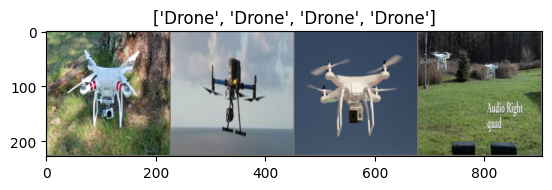

In [42]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Обучение 

In [43]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch=0; best_acc = 0.0; best_loss = sys.maxsize
    hist_loss_train = []; hist_acc_train = []; 
    hist_loss_val = []; hist_acc_val = []
    
    step = 0 

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
                hist_loss_train.append(epoch_loss)
                writer.add_scalar('Train loss', epoch_loss, global_step=epoch)
                hist_acc_train.append(epoch_acc)
                writer.add_scalar('Train Accuracy', epoch_acc, global_step=epoch)
                step += 1
            else:     
                hist_loss_val.append(epoch_loss)
                writer.add_scalar('Val loss', epoch_loss, global_step=epoch)
                hist_acc_val.append(epoch_acc)
                writer.add_scalar('Val Accuracy', epoch_acc, global_step=epoch)
                step += 1

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
    
        print()
        
        
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Визуализация итогов

In [44]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            t0 = time.time()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print("Время инфренса батча(мс): {:4f}".format((time.time()-t0)*1000))
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [45]:
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
  param.requires_grad = False
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Tensorboard
writer = SummaryWriter()

C:\Users\konto\anaconda3\envs\PythonGPU\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\konto\anaconda3\envs\PythonGPU\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
%load_ext tensorboard
%tensorboard --logdir=runs --host localhost

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2008), started 0:13:29 ago. (Use '!kill 2008' to kill it.)

In [50]:
import time
start_time = time.time()
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, 
                       num_epochs=100)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 0/99
----------
train Loss: 0.2375 Acc: 0.9015
val Loss: 0.4146 Acc: 0.8636

Epoch 1/99
----------
train Loss: 0.2315 Acc: 0.9031
val Loss: 0.5102 Acc: 0.8182

Epoch 2/99
----------
train Loss: 0.2885 Acc: 0.8851
val Loss: 0.5377 Acc: 0.8182

Epoch 3/99
----------
train Loss: 0.2623 Acc: 0.8933
val Loss: 0.3926 Acc: 0.8727

Epoch 4/99
----------
train Loss: 0.2345 Acc: 0.8982
val Loss: 0.3722 Acc: 0.8545

Epoch 5/99
----------
train Loss: 0.2272 Acc: 0.9130
val Loss: 0.5209 Acc: 0.8455

Epoch 6/99
----------
train Loss: 0.2970 Acc: 0.8670
val Loss: 0.4288 Acc: 0.8455

Epoch 7/99
----------
train Loss: 0.2612 Acc: 0.8818
val Loss: 0.6246 Acc: 0.8000

Epoch 8/99
----------
train Loss: 0.2609 Acc: 0.8966
val Loss: 0.4786 Acc: 0.8273

Epoch 9/99
----------
train Loss: 0.2243 Acc: 0.9064
val Loss: 0.4104 Acc: 0.8636

Epoch 10/99
----------
train Loss: 0.2778 Acc: 0.8588
val Loss: 0.4054 Acc: 0.8364

Epoch 11/99
----------
train Loss: 0.2599 Acc: 0.8933
val Loss: 0.4250 Acc: 0.8182

Ep

Время инфренса батча(мс): 4.998207


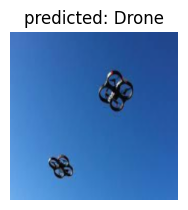

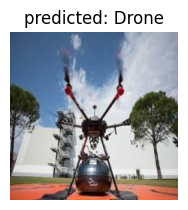

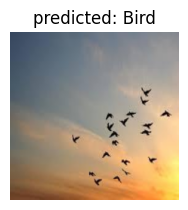

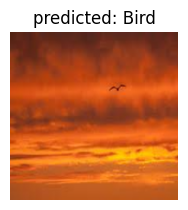

In [57]:
visualize_model(model_ft.to(device),num_images=4)

# Confusion matrix

[[43  7]
 [ 6 54]]


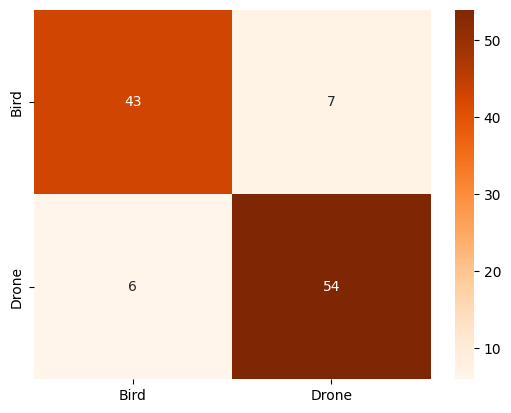

In [52]:
true_labels=[]
pred_labels=[]
for inputs, labels in dataloaders['val']:
  pred = model_ft.forward(inputs.to(device))
  _, pred = torch.max(pred, 1)
  labels.to(torch.device("cpu"))
  pred.to(torch.device("cpu"))
  true_labels.extend(labels.tolist());
  pred_labels.extend(pred.tolist());
cm=metrics.confusion_matrix(true_labels,pred_labels)
print(cm)
from pandas import DataFrame
import seaborn as sn
df_cm = DataFrame(cm, index=class_names, columns=class_names)
ax = sn.heatmap(df_cm, cmap='Oranges', annot=True)

In [53]:
from torchsummary import summary
summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [54]:

model_ft.eval()
model_ft=model_ft.to(torch.device("cpu"))

input_tensor = torch.rand(1,3,224,224)
script_model = torch.jit.trace(model_ft,input_tensor)
script_model.save("resnetBD.pt")